In [1]:
import os
import shutil
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall, MeanIoU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50
import segmentation_models as sm

Segmentation Models: using `keras` framework.


c:\Users\yehia\anaconda3\envs\tensorflow\lib\site-packages\rasterio\__init__.py:333: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


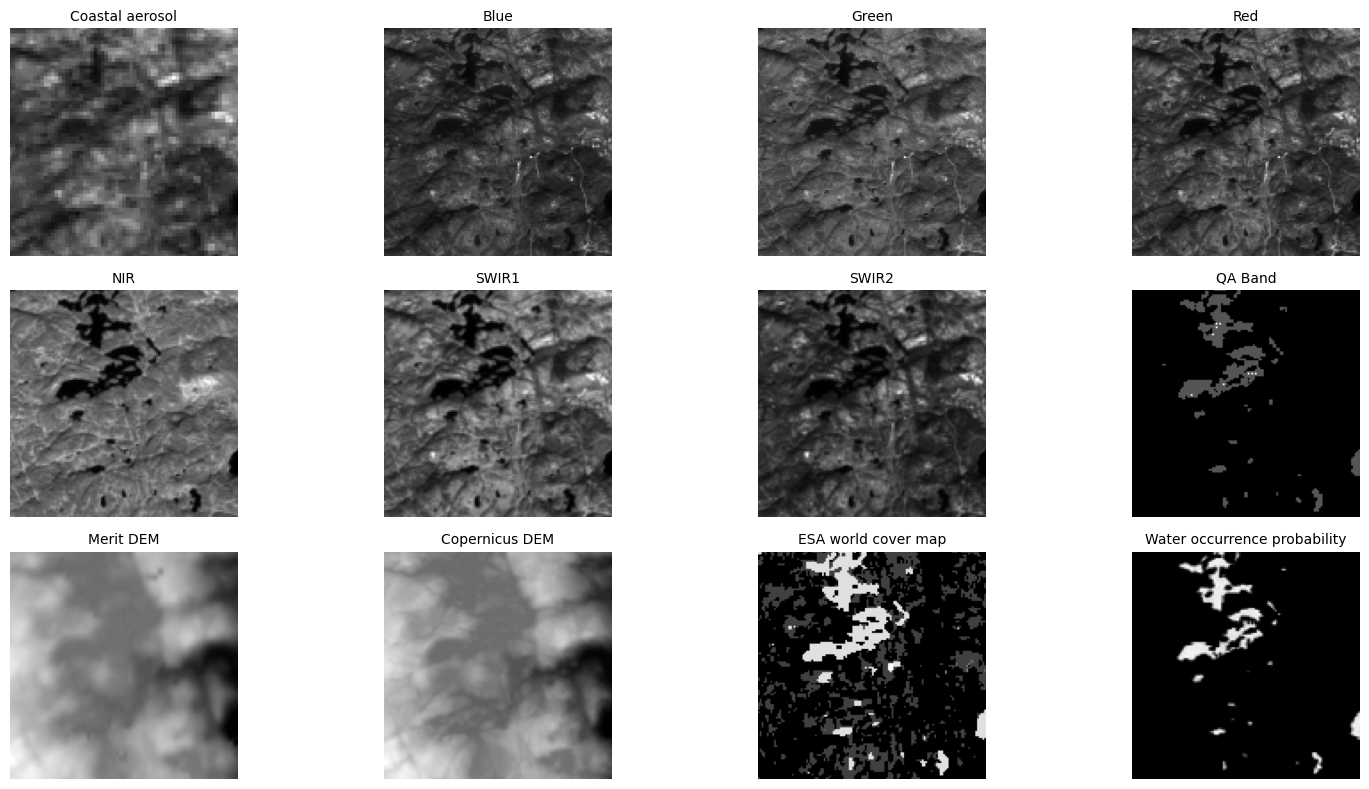

In [2]:
"""
this part of the code used to load one file from images folder and visualizing each of its band's separately.
each image has 12- Bands, their names are written in order to view the name of each band with the image.
"""



def plot_bands(image, band_names, bands_per_row=4):
    n_bands = image.shape[0]
    rows = n_bands // bands_per_row + (n_bands % bands_per_row > 0)
    fig, axes = plt.subplots(rows, bands_per_row, figsize=(16, 8))
    
    for i in range(n_bands):
        row, col = divmod(i, bands_per_row)
        ax = axes[row, col]
        ax.imshow(image[i], cmap='gray')
        ax.set_title(band_names[i], fontsize=10)
        ax.axis('off')

    # Hide any empty subplots
    for i in range(n_bands, rows * bands_per_row):
        fig.delaxes(axes.flat[i])
    
    plt.tight_layout()
    plt.show()


# Band names (in order)
band_names = [
    "Coastal aerosol", "Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2", 
    "QA Band", "Merit DEM", "Copernicus DEM", "ESA world cover map", 
    "Water occurrence probability"
]

# Load an example image
image_path = 'data/images/0.tif' 
with rasterio.open(image_path) as src:
    multispectral_image = src.read()  # (12, 128, 128) - all 12 bands

# Visualize all bands in a grid
plot_bands(multispectral_image, band_names)


In [3]:
"""
this funtion is for visualizing composites, it took 3-Bands and visualize them
"""
def show_composite(image, band_1, band_2, band_3, title):
    rgb_image = np.dstack((image[band_1], image[band_2], image[band_3]))
    rgb_image = rgb_image / np.max(rgb_image)  # Normalize for display
    plt.figure(figsize=(6, 6))
    plt.imshow(rgb_image)
    plt.title(title)
    plt.axis('off')
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


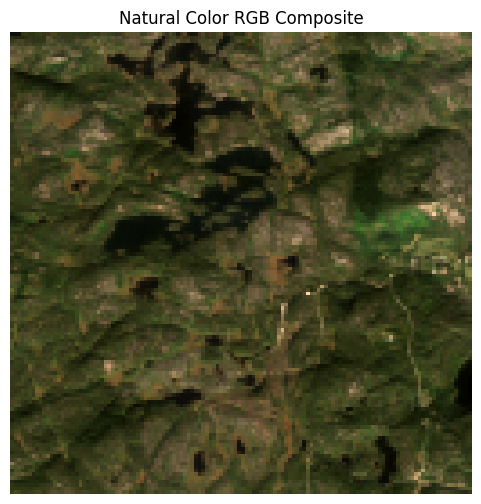

In [4]:
# Visualizing RGB Composite
show_composite(multispectral_image, 3, 2, 1, title="Natural Color RGB Composite") # R_Band:3, G_Band:2, B_band: 1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


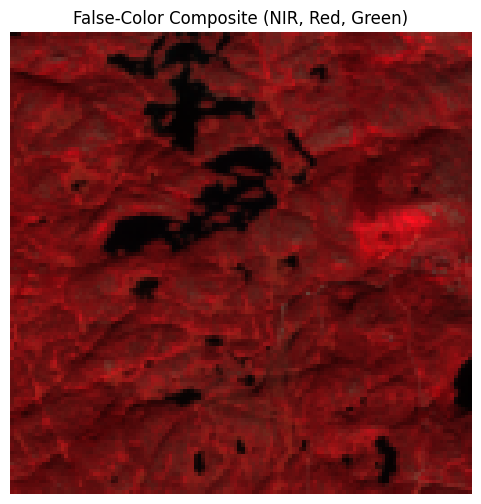

In [5]:
# Visualizing False-Color Composite
show_composite(multispectral_image, 4, 3, 2, title="False-Color Composite (NIR, Red, Green)") # NIR_Band:4, R_Band:3, G_band: 2


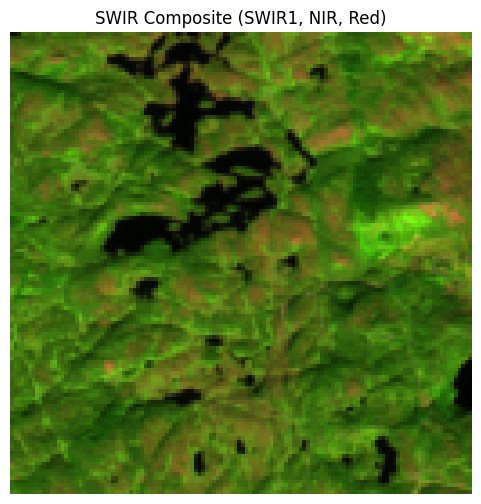

In [6]:
# Visualizing SWIR Composite
show_composite(multispectral_image, 5, 4, 3, title="SWIR Composite (SWIR1, NIR, Red)") # SWIR1_Band:5, NIR_Band:4, R_band: 3


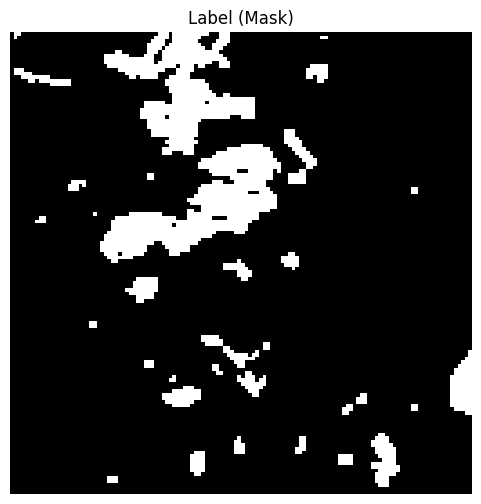

In [7]:
# Visualizing the label(Mask) of the image
label_path = f'data/labels/0.png'

label = Image.open(label_path)

# Plot the label image
plt.figure(figsize=(6, 6))
plt.imshow(label, cmap='gray')
plt.title('Label (Mask)')
plt.axis('off')
plt.show()


In [8]:
"""
This part of the code is responsible for loading, normalizing, augmenting, and preparing the dataset.
the pipeline has many steps, each one has explanation.
"""

# Constants
IMAGE_DIR = 'data/images'
LABEL_DIR = 'data/labels'
IMG_SIZE = (128, 128)  # Image size (width, height)
N_BANDS = 12  # Number of spectral bands

# Step 1: Compute Global Min and Max Values
def compute_global_min_max(image_dir):
    """
    Compute global min and max for each band across all images.
    """
    min_values = np.full(N_BANDS, np.inf)
    max_values = np.full(N_BANDS, -np.inf)
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    
    for img_file in image_files:
        img_path = os.path.join(image_dir, img_file)
        with rasterio.open(img_path) as src:
            image = src.read()  # (bands, height, width)
            min_values = np.minimum(min_values, np.min(image, axis=(1, 2)))
            max_values = np.maximum(max_values, np.max(image, axis=(1, 2)))
    
    return min_values, max_values

# Step 2: Load and Normalize Data Using Global Min and Max Values
def load_image(image_path, global_min, global_max):
    """
    Load a .tif multispectral image and normalize each band using global min and max values.
    """
    with rasterio.open(image_path) as src:
        image = src.read()  # (bands, height, width)
        # Normalize each band using global min and max values
        normalized_image = (image - global_min[:, np.newaxis, np.newaxis]) / \
                           (global_max[:, np.newaxis, np.newaxis] - global_min[:, np.newaxis, np.newaxis])
    return np.moveaxis(normalized_image, 0, -1)  # (height, width, bands)

def load_label(label_path):
    """
    Load a .png label mask.
    """
    label = Image.open(label_path)
    label = np.array(label)  
    return label


def load_data(image_dir, label_dir, global_min, global_max):
    """
    Load all images and labels, normalize, and return them as NumPy arrays.
    """
    image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.tif')])
    label_files = sorted([f for f in os.listdir(label_dir) if f.endswith('.png')])

    images, labels = [], []
    for img_file, lbl_file in zip(image_files, label_files):
        img_path = os.path.join(image_dir, img_file)
        lbl_path = os.path.join(label_dir, lbl_file)

        images.append(load_image(img_path, global_min, global_max))
        labels.append(load_label(lbl_path))

    return np.array(images), np.array(labels)

# Step 3: Augment the Data

def augment(image, label):
    """
    Apply random augmentations to the image and label.
    """
    # Add channel dimension to label if it doesn't exist
    if len(label.shape) == 2:
        label = tf.expand_dims(label, axis=-1)
    
    # Horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        label = tf.image.flip_left_right(label)
    
    # Vertical flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_up_down(image)
        label = tf.image.flip_up_down(label)
    
    # Random rotation
    if tf.random.uniform(()) > 0.5:
        image = tf.image.rot90(image)
        label = tf.image.rot90(label)
    
    # Remove channel dimension from label after augmentations
    if len(label.shape) == 3 and label.shape[-1] == 1:
       label = tf.squeeze(label, axis=-1)

    return image, label


# Step 4: Prepare the Dataset

def prepare_dataset(images, labels, batch_size, augment_data=True):
    """
    Prepare the dataset using TensorFlow's `tf.data.Dataset`.
    """
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    # if augment_data:
    #     dataset = dataset.map(lambda x, y: augment(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    
    dataset = dataset.shuffle(100).batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)
    return dataset

# Step 5: Split the Data into Train/Validation/Test

def split_data(images, labels, test_size=0.15, val_size=0.15):
    """
    Split the data into training, validation, and test sets.
    Where 70% for training, 15% for validation, 15% for testing.
    """
    X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=test_size+val_size, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size/(test_size+val_size), random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Step 6: Main Pipeline

def preprocessing_pipeline(image_dir=IMAGE_DIR, label_dir=LABEL_DIR, batch_size=32):
    """
    Complete preprocessing pipeline to load, normalize, augment, and prepare the dataset.
    """
    # Compute global min and max values
    global_min, global_max = compute_global_min_max(image_dir)
    
    # Load and normalize the data
    images, labels = load_data(image_dir, label_dir, global_min, global_max)
    
    # Split into train, validation, and test sets
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(images, labels)

    # Prepare TensorFlow datasets
    train_dataset = prepare_dataset(X_train, y_train, batch_size=batch_size, augment_data=True)
    val_dataset = prepare_dataset(X_val, y_val, batch_size=batch_size, augment_data=False)
    test_dataset = prepare_dataset(X_test, y_test, batch_size=batch_size, augment_data=False)

    return train_dataset, val_dataset, test_dataset


In [9]:
# Running the pipeline
train_ds, val_ds, test_ds = preprocessing_pipeline()

print("Preprocessing complete. Datasets are ready for model training.")

Preprocessing complete. Datasets are ready for model training.


In [10]:
def compute_statistics(dataset):
    """Compute and print basic statistics of the dataset."""
    for images, labels in dataset.take(1):  # Take one batch
        print("Image statistics:")
        print(f"Image shape: {images.shape}")
        print(f"Image data type: {images.dtype}")
        print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
        print(f"Max pixel value: {tf.reduce_max(images).numpy()}")
        print(f"Mean pixel value: {tf.reduce_mean(images).numpy()}")
        print(f"Standard deviation: {tf.math.reduce_std(images).numpy()}")
        
        print("\nLabel statistics:")
        print(f"Label shape: {labels.shape}")
        print(f"Label data type: {labels.dtype}")
        print(f"Unique label values: {np.unique(labels.numpy())}")

compute_statistics(train_ds)


Image statistics:
Image shape: (32, 128, 128, 12)
Image data type: <dtype: 'float64'>
Min pixel value: 0.0
Max pixel value: 0.9214659685863874
Mean pixel value: 0.20198783362816067
Standard deviation: 0.20664050142781049

Label statistics:
Label shape: (32, 128, 128)
Label data type: <dtype: 'uint8'>
Unique label values: [0 1]


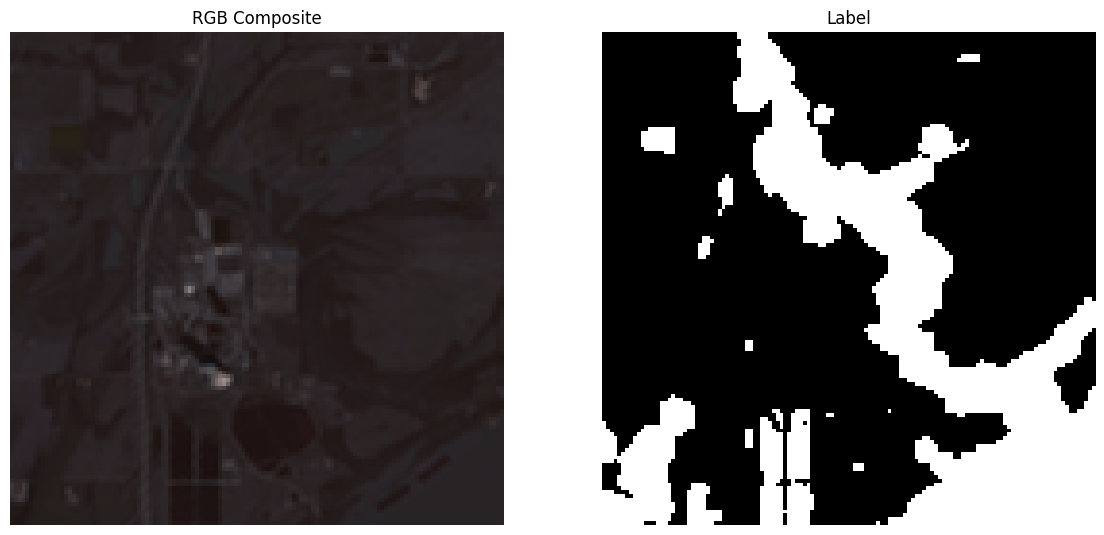

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_rgb_and_label(image, label):
    """
    Visualize an RGB composite image and its corresponding label side by side.
    to make sure the pipeline work correctly without problems.
    """

    red = image[:, :, 1]  # Red band
    green = image[:, :, 2]  # Green band
    blue = image[:, :, 3]  # Blue band

    rgb_image = np.stack([red, green, blue], axis=-1)  # Stack into RGB format
    
    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display RGB Image
    axs[0].imshow(rgb_image)
    axs[0].set_title('RGB Composite')
    axs[0].axis('off')
    
    # Display Label Image
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title('Label')
    axs[1].axis('off')
    
    plt.show()

# Visualize one sample from the training dataset
for image, label in train_ds.take(1):
    # Convert tensors to numpy arrays
    image_np = image.numpy()[0]  # Get the first sample
    label_np = label.numpy()[0]  # Get the corresponding label
    visualize_rgb_and_label(image_np, label_np)
    break


In [12]:
def unet_model(input_shape=(128, 128, 12), num_classes=1):
    """
    Build and return a U-Net model using a pretrained encoder with modifications for input channels.
    
    Parameters:
    - input_shape: Shape of the input image (height, width, channels)
    - num_classes: Number of output classes (for binary classification, it's 1)
    
    Returns:
    - model: U-Net model instance
    """
    # Load a pretrained U-Net model with the ResNet50 encoder
    base_model = sm.Unet('resnet50', encoder_weights='imagenet', input_shape=(128, 128, 3))
    
    # Modify the input layer to handle 12 channels
    inputs = Input(shape=input_shape)
    x = Conv2D(3, (1, 1), activation='relu')(inputs)  # Convert 12 channels to 3 channels
    
    # Use the base U-Net model
    x = base_model(x, training=True)  # Directly use the base model with 3-channel input
    
    # Output layer for binary classification
    outputs = Conv2D(num_classes, (1, 1), activation='sigmoid')(x)
    
    model = Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the U-Net model
model = unet_model()


In [13]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall(), MeanIoU(num_classes=2)])


In [14]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 12)]    0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 3)       39        
                                                                 
 model_1 (Functional)        (None, 128, 128, 1)       32561114  
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 1)       2         
                                                                 
Total params: 32,561,155
Trainable params: 32,513,597
Non-trainable params: 47,558
_________________________________________________________________


In [15]:
# Define EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7
)


In [16]:
history = model.fit(train_ds,
                    epochs=80,
                    validation_data=val_ds,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/80
7/7 [==============================] - 21s 917ms/step - loss: 0.8338 - accuracy: 0.2739 - precision: 0.2739 - recall: 1.0000 - mean_io_u: 0.3631 - val_loss: 0.7869 - val_accuracy: 0.2593 - val_precision: 0.2593 - val_recall: 1.0000 - val_mean_io_u: 0.3703 - lr: 3.0000e-04
Epoch 2/80
7/7 [==============================] - 2s 238ms/step - loss: 0.7564 - accuracy: 0.2739 - precision: 0.2739 - recall: 1.0000 - mean_io_u: 0.3631 - val_loss: 0.7594 - val_accuracy: 0.2593 - val_precision: 0.2593 - val_recall: 1.0000 - val_mean_io_u: 0.3703 - lr: 3.0000e-04
Epoch 3/80
7/7 [==============================] - 2s 233ms/step - loss: 0.7298 - accuracy: 0.2739 - precision: 0.2739 - recall: 1.0000 - mean_io_u: 0.3631 - val_loss: 0.7402 - val_accuracy: 0.2593 - val_precision: 0.2593 - val_recall: 1.0000 - val_mean_io_u: 0.3703 - lr: 3.0000e-04
Epoch 4/80
7/7 [==============================] - 2s 228ms/step - loss: 0.7139 - accuracy: 0.2739 - precision: 0.2739 - recall: 1.0000 - mean_io_u: 0.

In [20]:
print(history.history.keys())


dict_keys(['loss', 'accuracy', 'precision', 'recall', 'mean_io_u', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall', 'val_mean_io_u', 'lr'])


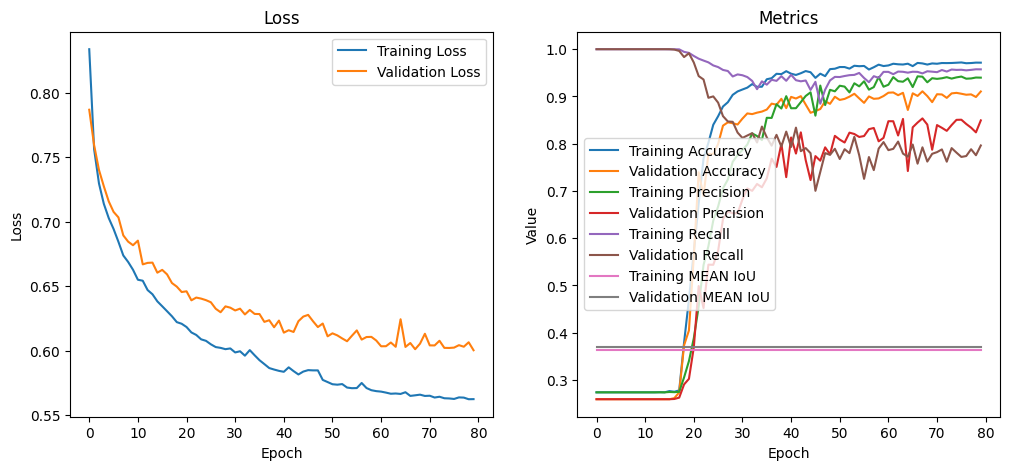

In [21]:
# Plot training and validation metrics
def plot_metrics(history):
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Metrics
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.plot(history.history['precision'], label='Training Precision')
    plt.plot(history.history['val_precision'], label='Validation Precision')
    plt.plot(history.history['recall'], label='Training Recall')
    plt.plot(history.history['val_recall'], label='Validation Recall')
    plt.plot(history.history['mean_io_u'], label='Training MEAN IoU')
    plt.plot(history.history['val_mean_io_u'], label='Validation MEAN IoU')
    plt.title('Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Value')
    plt.legend()

    plt.show()

# Visualize the training history
plot_metrics(history)

In [22]:
# Evaluate the model on the test dataset
test_loss, test_accuracy, test_precision, test_recall, test_iou = model.evaluate(test_ds)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test IoU: {test_iou}")


2/2 [==============================] - 0s 97ms/step - loss: 0.6187 - accuracy: 0.9193 - precision: 0.7583 - recall: 0.8585 - mean_io_u: 0.4028
Test Loss: 0.6186652183532715
Test Accuracy: 0.9192783236503601
Test Precision: 0.7582995891571045
Test Recall: 0.8585027456283569
Test IoU: 0.40277695655822754


1/1 [==============================] - 0s 78ms/step


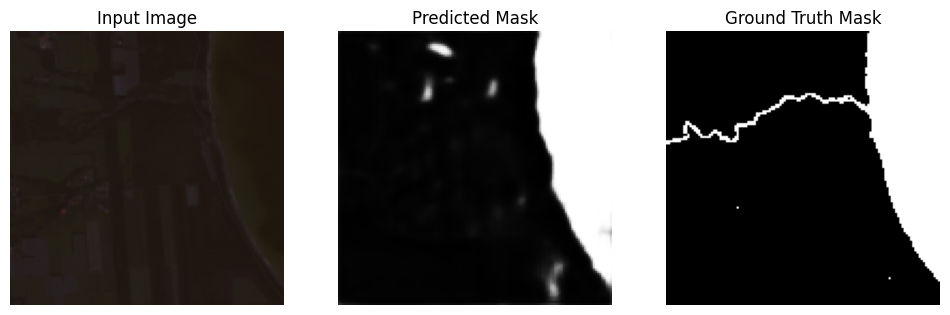

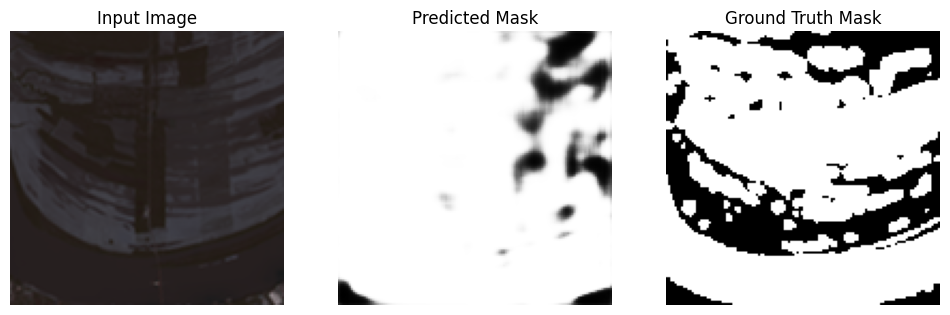

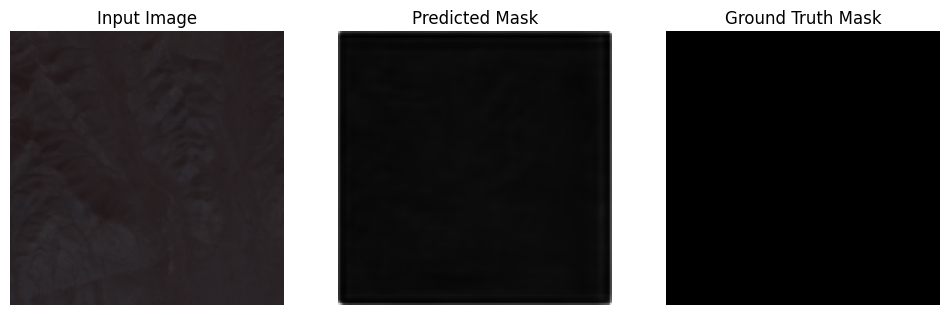

In [29]:
# Predict on test dataset and visualize a few predictions alongside true labels
for images, true_labels in test_ds.take(1):
    # Make predictions for the batch
    pred_masks = model.predict(images)

    for i in range(3):  # Visualize 3 samples
        plt.figure(figsize=(12, 6))

        # Extract RGB bands (1, 2, 3)
        rgb_image = images[i][:, :, 1:4]

        # Display the RGB Image
        plt.subplot(1, 3, 1)
        plt.imshow(rgb_image)
        plt.title('Input Image')
        plt.axis('off')

        # Display the Predicted Mask
        plt.subplot(1, 3, 2)
        plt.imshow(pred_masks[i], cmap='gray') 
        plt.title('Predicted Mask')
        plt.axis('off')

        # Display the Ground Truth Mask
        plt.subplot(1, 3, 3)
        plt.imshow(true_labels[i].numpy(), cmap='gray')
        plt.title('Ground Truth Mask')
        plt.axis('off')

        plt.show()


In [30]:
# Save the trained model
model.save('FINE-TUNING-U-NET.h5')

In [31]:
from tensorflow.keras.models import load_model

# Load the model
loaded_model = load_model('FINE-TUNING-U-NET.h5', custom_objects={'Precision': tf.keras.metrics.Precision,
                                                           'Recall': tf.keras.metrics.Recall,
                                                           'MeanIoU': tf.keras.metrics.MeanIoU})


1/1 [==============================] - 2s 2s/step


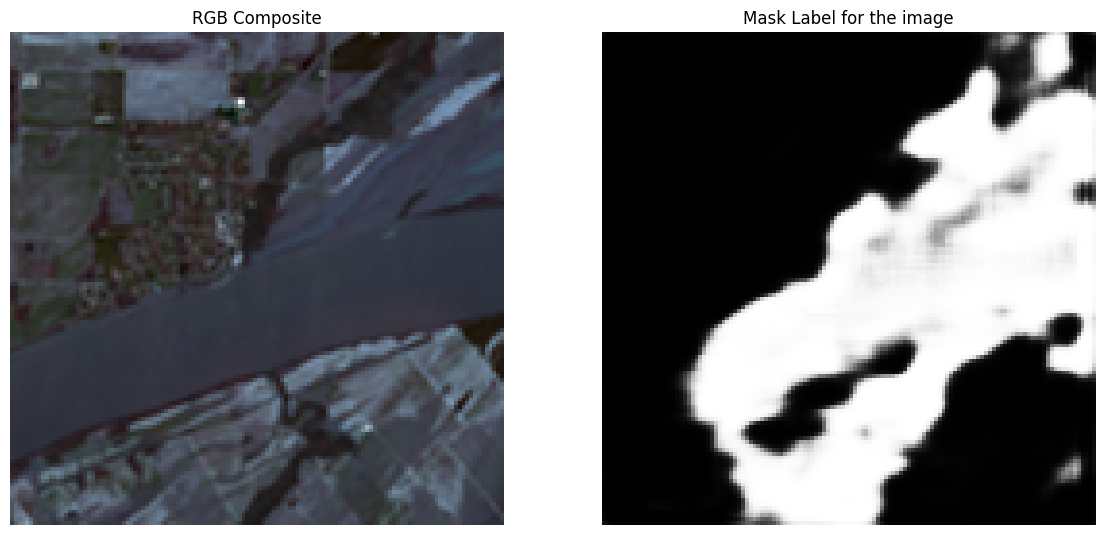

In [32]:
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import tensorflow as tf

def load_image(image_path):
    """
    Load a .tif multispectral image and normalize each band separately using its own min and max values
    (as we did in the data used for training the model).
    """
    with rasterio.open(image_path) as src:
        image = src.read()  # (bands, height, width)
        
        # Calculate min and max for each band separately
        min_values = np.min(image, axis=(1, 2))
        max_values = np.max(image, axis=(1, 2))
        
        # Normalize each band using its own min and max values
        normalized_image = (image - min_values[:, np.newaxis, np.newaxis]) / \
                           (max_values[:, np.newaxis, np.newaxis] - min_values[:, np.newaxis, np.newaxis])
        
    return np.moveaxis(normalized_image, 0, -1)  # (height, width, bands)

def create_rgb_composite(image):
    """
    Create an RGB composite from the normalized image.
    """
    # Extract RGB bands (1, 2, 3)
    red = image[:, :, 1]  # Red band
    green = image[:, :, 2]  # Green band
    blue = image[:, :, 3]  # Blue band

    # Stack the channels into an RGB composite image
    rgb_image = np.stack([red, green, blue], axis=-1)
    return rgb_image

def visualize_rgb_and_label(image, label):
    """
    Visualize an RGB composite image and its corresponding label side by side.
    """
    # Create RGB composite
    rgb_image = create_rgb_composite(image)
    
    # Plot the images
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    # Display RGB Image
    axs[0].imshow(rgb_image)
    axs[0].set_title('RGB Composite')
    axs[0].axis('off')
    
    # Display Label Image
    axs[1].imshow(label, cmap='gray')
    axs[1].set_title('Mask Label for the image')
    axs[1].axis('off')
    
    plt.show()

def preprocess_and_predict(image_path, model):
    """
    Preprocess a new image and predict the mask using the provided model.
    """

    new_image = load_image(image_path)
    
    # Add batch dimension to match input shape: (1, 128, 128, 12)
    new_image = tf.expand_dims(new_image, axis=0)
    
    # Predict the mask using the loaded model
    predicted_mask = model.predict(new_image)
    
    # Convert from tensor to numpy for display
    image_for_display = new_image[0].numpy()
    # Remove the batch dimenion
    predicted_mask_for_display = predicted_mask.squeeze()
    
    # Visualize the RGB composite and predicted mask
    visualize_rgb_and_label(image_for_display, predicted_mask_for_display)

# Test with an image
image_path = 'data/images/22.tif'
preprocess_and_predict(image_path, loaded_model)

